# Simulation Overview

This document provides an overview of a Federated Learning (FL) simulation. The simulation includes 10 rounds, involves 30 clients, and utilizes the Federated Averaging (FedAvg) algorithm. The clients are grouped into different federations based on user criteria.

## Key Details

- **Number of Rounds:** 9
- **Number of Clients:** 30
- **Algorithm Used:** Federated Averaging (FedAvg)
- **Federations:** Grouped based on user criteria

## Description

The simulation is designed to illustrate the implementation and performance of a Federated Learning model using the FedAvg algorithm across multiple federations. Each federation represents a subset of the total clients, grouped according to specific user-defined characteristics. The process can be broken down as follows:

### Initialization

1. **Client Distribution:** The 30 clients are divided into various federations based on predefined criteria.
2. **Model Initialization:** A global model is initialized and shared with all clients.

### Federated Learning Process
- **Local Training:** Each client trains the model locally on its own data.
- **Model Updates:** After local training, clients send their model updates to their respective federation.
- **Aggregation:** Within each federation, local updates are aggregated using the FedAvg algorithm to create a federation model.
- **Global Aggregation:** Federation models are further aggregated to update the global model.
- **Model Distribution:** The updated global model is distributed back to all clients for the next round of local training.

This process is made 9 times, one for each round, in order to maximize the accuracy

### Evaluation

- **Performance Metrics:** The performance of the global model is evaluated at the end of each round using relevant metrics (e.g., accuracy, loss).
- **Convergence:** The simulation continues until the model performance stabilizes or the predefined number of rounds is reached.

## Conclusion

This simulation demonstrates the dynamics of Federated Learning with multiple federations using the FedAvg algorithm. By grouping clients into federations based on user criteria, the simulation aims to enhance the efficiency and performance of the learning process.


In [1]:
from typing import Dict, List, Tuple

import tensorflow as tf

import flwr as fl
from flwr.common import Metrics
from flwr.simulation.ray_transport.utils import enable_tf_gpu_growth

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [2]:
VERBOSE = 0
NUM_CLIENTS = 30

# folder dataset
PATH_TRAIN_X = "../UCI_HAR_Dataset/train/X_train.txt"
PATH_TRAIN_Y = "../UCI_HAR_Dataset/train/y_train.txt"

PATH_TEST_X = "../UCI_HAR_Dataset/test/X_test.txt"
PATH_TEST_Y = "../UCI_HAR_Dataset/test/y_test.txt"

PATH_TRAIN_SBJ = "../UCI_HAR_Dataset/train/subject_train.txt"
PATH_TEST_SBJ = "../UCI_HAR_Dataset/test/subject_test.txt"
PATH_FT = "../UCI_HAR_Dataset/features.txt"

features = pd.read_csv(PATH_FT, sep=" ", header=None, index_col=0).reset_index()

# training X
df_x_train = pd.read_fwf(PATH_TRAIN_X, header=None)
df_x_train.rename(columns=features[1], inplace=True)

# activity subject (train)
df_sbj_train = pd.read_csv(PATH_TRAIN_SBJ, sep=" ", header=None)
df_x_train['user'] = df_sbj_train.values
arr_sbj_train = (df_sbj_train.iloc[:,0]).to_list()
# training Y
y_train_col = pd.read_fwf(PATH_TRAIN_Y, header=None)

# testing X
df_x_test = pd.read_fwf(PATH_TEST_X, header=None)
df_x_test.rename(columns=features[1], inplace=True)
# activity subject (test)
df_sbj_test = pd.read_csv(PATH_TEST_SBJ, sep=" ", header=None)
df_x_test['user'] = df_sbj_test.values
arr_sbj_test = (df_sbj_test.iloc[:,0]).to_list()
# testing Y
y_test_col = pd.read_fwf(PATH_TEST_Y, header=None)

In [3]:
def get_model():
    # model definition
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(512, activation='relu', input_shape=(features.shape[0],)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(7, activation='softmax')
    ])
    model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

In [4]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, X_train, X_test, y_train, y_test) -> None:
        super().__init__()
        # Create model
        self.model = get_model()
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        self.model.fit(self.X_train, self.y_train, epochs=3, batch_size=32, verbose=VERBOSE)
        return self.model.get_weights(), len(self.X_train), {}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        loss, accuracy = self.model.evaluate(self.X_test, self.y_test)
        return loss, len(self.X_test), {"accuracy": float(accuracy)}

In [5]:
def get_client_fn():

    def client_fn(cid) -> fl.client.Client:
        cid = int(cid) + 1

        usr_act_train = []                              # activity made by user (train)
        usr_act_test = []                               # activity made by user (test)

        for i in range(len(arr_sbj_train)):
            if(arr_sbj_train[i] == cid):
                usr_act_train.append(i)
        
        for i in range(len(arr_sbj_test)):
            if(arr_sbj_test[i] == cid):
                usr_act_test.append(i)
        
        df_ext_train = pd.DataFrame(dtype=float)
        df_ext_test = pd.DataFrame(dtype=float)
        y_ext_train = pd.DataFrame(dtype=float)
        y_ext_test = pd.DataFrame(dtype=float)

        for i in range(len(usr_act_train)):
            index = usr_act_train[i]
            x_row = df_x_train.iloc[index,:561]
            df_ext_train = pd.concat([df_ext_train, x_row], ignore_index=True, axis=1)
            y_row = y_train_col.iloc[index]
            y_ext_train = pd.concat([y_ext_train, y_row], ignore_index=True, axis=1)

        for i in range(len(usr_act_test)):
            index = usr_act_test[i]
            x_row = df_x_test.iloc[index,:561]
            df_ext_test = pd.concat([df_ext_test, x_row], ignore_index=True, axis=1)
            y_row = y_test_col.iloc[index]
            y_ext_test = pd.concat([y_ext_test, y_row], ignore_index=True, axis=1)

        df_ext_train = df_ext_train.T
        y_ext_train = y_ext_train.T
        df_ext_test = df_ext_test.T
        y_ext_test = y_ext_test.T

        X_train = np.array(df_ext_train)
        y_train = np.array(y_ext_train)
        X_test = np.array(df_ext_test)
        y_test = np.array(y_ext_test)

        if (len(y_train) == 0) | (len(y_test) == 0):
            if (len(y_train) == 0) & (len(y_test) == 0):
                X_train, X_test, y_train, y_test = np.array()
            else:
                if (len(y_train) == 0):
                    X_train, X_test, y_train, y_test = train_test_split(X_test, y_test, random_state=42, test_size=0.3)
                else:
                    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, random_state=42, test_size=0.3)
        

        # Create and return client
        return FlowerClient(X_train, X_test, y_train, y_test).to_client()

    return client_fn


def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}


def get_evaluate_fn(X_test, y_test):
    # The `evaluate` function will be called after every round by the strategy
    def evaluate(
        server_round: int,
        parameters: fl.common.NDArrays,
        config: Dict[str, fl.common.Scalar],
    ):
        model = get_model()  # Construct the model
        model.set_weights(parameters)  # Update model with the latest parameters
        loss, accuracy = model.evaluate(X_test, y_test, verbose=VERBOSE)
        return loss, {"accuracy": accuracy}

    return evaluate

In [6]:
# Enable GPU growth in your main process
enable_tf_gpu_growth()

# Create FedAvg strategy
myStrategy = fl.server.strategy.FedAvg(
    fraction_fit=0.1,                   # Sample 10% of available clients for training
    fraction_evaluate=0.05,             # Sample 5% of available clients for evaluation
    min_fit_clients=10,                  # Never sample less than 3 clients for training
    min_evaluate_clients=10,             # Never sample less than 3 clients for evaluation
    min_available_clients=int(
        NUM_CLIENTS
    ),                                  # Wait until at least 30 clients are available
    evaluate_metrics_aggregation_fn=weighted_average,  # aggregates federated metrics
    # evaluate_fn=get_evaluate_fn(centralized_testset),  # global evaluation function
)

# With a dictionary, you tell Flower's VirtualClientEngine that each
# client needs exclusive access to these many resources in order to run
client_resources = {"num_cpus": 0.5, "num_gpus": 0}

# Start simulation
history = fl.simulation.start_simulation(
    client_fn=get_client_fn(),
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=30),
    strategy=myStrategy,
    client_resources=client_resources,
    actor_kwargs={
        "on_actor_init_fn": enable_tf_gpu_growth  # Enable GPU growth upon actor init.
    },
)

INFO :      Starting Flower simulation, config: num_rounds=30, no round_timeout


2024-10-08 17:54:08,948	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 8.0, 'memory': 3387978548.0, 'node:127.0.0.1': 1.0, 'object_store_memory': 1693989273.0, 'node:__internal_head__': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 0.5, 'num_gpus': 0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 16 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(ClientAppActor pid=12276) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=12276)   super().__init__

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6764 - loss: 1.2018  
1/4 ━━━━━━━━━━━━━━━━━━━━ 1s 437ms/step - accuracy: 0.4688 - loss: 1.2693
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5146 - loss: 1.2424  


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 30)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 30)
(ClientAppActor pid=12272) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 20x across cluster]
(ClientAppActor pid=12272)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 20x across cluster]


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.5684 - loss: 0.9042
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6981 - loss: 1.0962   [repeated 8x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 30)
(ClientAppActor pid=12270) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 14x across cluster]
(ClientAppActor pid=12270)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 14x across cluster]
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 30)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6201 - loss: 0.8925   [repeated 10x across cluster]


(ClientAppActor pid=12267) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 12x across cluster]
(ClientAppActor pid=12267)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 30)


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9062 - loss: 0.4407
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9004 - loss: 0.4908  


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 30)
(ClientAppActor pid=12271) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 14x across cluster]
(ClientAppActor pid=12271)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 14x across cluster]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8503 - loss: 0.3679  [repeated 9x across cluster]
1/4 ━━━━━━━━━━━━━━━━━━━━ 1s 357ms/step - accuracy: 0.7188 - loss: 0.4116
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7679 - loss: 0.3571  


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 30)
(ClientAppActor pid=12269) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 14x across cluster]
(ClientAppActor pid=12269)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 14x across cluster]
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 30)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8386 - loss: 0.3525   [repeated 9x across cluster]
1/4 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step - accuracy: 0.6875 - loss: 0.8428
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7086 - loss: 0.8343  


(ClientAppActor pid=12267) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 13x across cluster]
(ClientAppActor pid=12267)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 13x across cluster]
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 30)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 30)
(ClientAppActor pid=12271) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a la

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8862 - loss: 0.2307   [repeated 8x across cluster]
1/4 ━━━━━━━━━━━━━━━━━━━━ 1s 497ms/step - accuracy: 0.9375 - loss: 0.3016
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8370 - loss: 0.3671  


(ClientAppActor pid=12273) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 3x across cluster]
(ClientAppActor pid=12273)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 3x across cluster]


4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7251 - loss: 0.4745 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 30)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 30)
(ClientAppActor pid=12267) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 17x across cluster]
(ClientAppActor pid=12267)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 17x across cluster]


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8598 - loss: 0.2397  [repeated 8x across cluster]
1/4 ━━━━━━━━━━━━━━━━━━━━ 2s 800ms/step - accuracy: 0.8750 - loss: 0.2731
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8984 - loss: 0.2435  


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 30)
(ClientAppActor pid=12270) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 15x across cluster]
(ClientAppActor pid=12270)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 15x across cluster]
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 30)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7773 - loss: 0.3870   [repeated 8x across cluster]
1/4 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step - accuracy: 0.7188 - loss: 0.5485
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7632 - loss: 0.4231 


(ClientAppActor pid=12270) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 8x across cluster]
(ClientAppActor pid=12270)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 8x across cluster]


4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7942 - loss: 0.2790 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 30)
(ClientAppActor pid=12271) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 16x across cluster]
(ClientAppActor pid=12271)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 16x across cluster]
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 30)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9160 - loss: 0.2017   [repeated 8x across cluster]
1/4 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step - accuracy: 0.8125 - loss: 0.3855
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7705 - loss: 0.4082 


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 30)
(ClientAppActor pid=12267) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 11x across cluster]
(ClientAppActor pid=12267)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 11x across cluster]
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 30)
(ClientAppActor pid=12271) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a l

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.8474 - loss: 0.4151 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8085 - loss: 0.2955   [repeated 8x across cluster]
1/4 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step - accuracy: 0.9375 - loss: 0.2017
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9291 - loss: 0.1861 


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 10 clients (out of 30)
(ClientAppActor pid=12268) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 10x across cluster]
(ClientAppActor pid=12268)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 10x across cluster]
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 30)
(ClientAppActor pid=12267) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a l

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8260 - loss: 0.5508   [repeated 6x across cluster]
1/4 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step - accuracy: 0.8750 - loss: 0.3804 [repeated 3x across cluster]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8377 - loss: 0.5269   [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 10 clients (out of 30)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 30)
(ClientAppActor pid=12274) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 18x across cluster]
(ClientAppActor pid=12274)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 18x across cluster]
(ClientAppActor pid=12267) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a l

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8136 - loss: 0.5530   [repeated 9x across cluster]
1/4 ━━━━━━━━━━━━━━━━━━━━ 21s 7s/step - accuracy: 0.8438 - loss: 0.3679
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8501 - loss: 0.3556  
2/4 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.8359 - loss: 0.3696
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 0.8329 - loss: 0.3428


(ClientAppActor pid=12272) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=12272)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 10 clients (out of 30)
(ClientAppActor pid=12268) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 8x across cluster]
(ClientAppActor pid=12268)   super().__init__(acti

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9536 - loss: 0.1513   [repeated 10x across cluster]
1/4 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step - accuracy: 1.0000 - loss: 0.0995
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9909 - loss: 0.1119 


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 10 clients (out of 30)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 30)
(ClientAppActor pid=12268) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 20x across cluster]
(ClientAppActor pid=12268)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 20x across cluster]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9682 - loss: 0.1793   [repeated 9x across cluster]


(ClientAppActor pid=12267) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 2x across cluster]
(ClientAppActor pid=12267)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 2x across cluster]


4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9382 - loss: 0.1874
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9156 - loss: 0.2013 


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 10 clients (out of 30)
(ClientAppActor pid=12274) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 10x across cluster]
(ClientAppActor pid=12274)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 10x across cluster]
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 30)
(ClientAppActor pid=12273) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a l

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9377 - loss: 0.2091   [repeated 8x across cluster]
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.9062 - loss: 0.8204
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8728 - loss: 0.8807  


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 10 clients (out of 30)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 30)
(ClientAppActor pid=12272) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 19x across cluster]
(ClientAppActor pid=12272)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 19x across cluster]
(ClientAppActor pid=12273) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a l

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.8091 - loss: 0.3463 [repeated 9x across cluster]
1/4 ━━━━━━━━━━━━━━━━━━━━ 2s 857ms/step - accuracy: 0.8750 - loss: 0.4073
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8940 - loss: 0.4177 


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 10 clients (out of 30)
(ClientAppActor pid=12276) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 11x across cluster]
(ClientAppActor pid=12276)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 11x across cluster]
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 30)
(ClientAppActor pid=12275) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a l

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8720 - loss: 0.6999  [repeated 8x across cluster]
1/4 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step - accuracy: 0.9062 - loss: 0.4796
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8757 - loss: 0.4384 


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 10 clients (out of 30)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 30)
(ClientAppActor pid=12271) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 18x across cluster]
(ClientAppActor pid=12271)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 18x across cluster]


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 1.0000 - loss: 0.1436
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8083 - loss: 0.6861   [repeated 9x across cluster]
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9800 - loss: 0.1878  


(ClientAppActor pid=12274) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=12274)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=12275) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=12275)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9178 - loss: 0.3279
1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step - accuracy: 0.8438 - loss: 0.6882
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9375 - loss: 0.1708  
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8055 - loss: 0.3033
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8488 - loss: 0.5533 


(ClientAppActor pid=12273) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 5x across cluster]
(ClientAppActor pid=12273)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 5x across cluster]


1/4 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 1.0000 - loss: 0.0390
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8776 - loss: 0.2392 
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9910 - loss: 0.0526
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9289 - loss: 0.2717  


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 10 clients (out of 30)
(ClientAppActor pid=12270) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 9x across cluster]
(ClientAppActor pid=12270)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 9x across cluster]
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 30)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9199 - loss: 0.1976   [repeated 3x across cluster]
1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step - accuracy: 1.0000 - loss: 0.0792
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9812 - loss: 0.0860 


(ClientAppActor pid=12274) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 8x across cluster]
(ClientAppActor pid=12274)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 8x across cluster]
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 10 clients (out of 30)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 30)
(ClientAppActor pid=12274) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a lay

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8491 - loss: 0.9378   [repeated 7x across cluster]
1/4 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step - accuracy: 0.9062 - loss: 0.5026 [repeated 2x across cluster]
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9426 - loss: 0.1493  
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8911 - loss: 0.4664  
1/4 ━━━━━━━━━━━━━━━━━━━━ 1s 355ms/step - accuracy: 0.5938 - loss: 2.9718 [repeated 3x across cluster]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8264 - loss: 0.4198  


(ClientAppActor pid=12276) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 5x across cluster]
(ClientAppActor pid=12276)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 5x across cluster]


2/3 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.9766 - loss: 0.1134   
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step - accuracy: 0.9830 - loss: 0.0980
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.6296 - loss: 2.7721
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9718 - loss: 0.0785  


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 10 clients (out of 30)
(ClientAppActor pid=12267) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 6x across cluster]
(ClientAppActor pid=12267)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 6x across cluster]
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 30)
(ClientAppActor pid=12272) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a lay

1/4 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step - accuracy: 0.9375 - loss: 0.1163
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9068 - loss: 0.1466   [repeated 2x across cluster]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9540 - loss: 0.1012   [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 10 clients (out of 30)
(ClientAppActor pid=12270) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 15x across cluster]
(ClientAppActor pid=12270)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 15x across cluster]
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 30)
(ClientAppActor pid=12268) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a l

1/4 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step - accuracy: 0.9062 - loss: 0.1862
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8573 - loss: 0.2191   [repeated 9x across cluster]
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9085 - loss: 0.1700 
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9910 - loss: 0.0353


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 10 clients (out of 30)
(ClientAppActor pid=12270) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 14x across cluster]
(ClientAppActor pid=12270)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 14x across cluster]
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 30)


1/4 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step - accuracy: 1.0000 - loss: 0.0224 [repeated 2x across cluster]
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9475 - loss: 0.1320   [repeated 8x across cluster]
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9303 - loss: 0.1928  


(ClientAppActor pid=12267) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 9x across cluster]
(ClientAppActor pid=12267)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 9x across cluster]
(ClientAppActor pid=12273) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 4x across cluster]
(ClientAppActor pid=12273)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 4x across cluster]


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9780 - loss: 0.0865   [repeated 7x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 10 clients (out of 30)
(ClientAppActor pid=12276) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 7x across cluster]
(ClientAppActor pid=12276)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 7x across cluster]
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 30)
(ClientAppActor pid=12269) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a lay

1/4 ━━━━━━━━━━━━━━━━━━━━ 2s 726ms/step - accuracy: 0.9375 - loss: 0.1727
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8392 - loss: 0.2970   [repeated 2x across cluster]
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9375 - loss: 0.1469


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 10 clients (out of 30)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9535 - loss: 0.3119  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9909 - loss: 0.0838


(ClientAppActor pid=12270) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 14x across cluster]
(ClientAppActor pid=12270)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 14x across cluster]
(ClientAppActor pid=12274) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 5x across cluster]
(ClientAppActor pid=12274)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 5x across cluster]
INFO :      aggregate_fit: recei

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.9062 - loss: 0.5173
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9602 - loss: 0.0716   [repeated 8x across cluster]


(ClientAppActor pid=12267) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 2x across cluster]
(ClientAppActor pid=12267)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 2x across cluster]


1/4 ━━━━━━━━━━━━━━━━━━━━ 2s 815ms/step - accuracy: 0.7812 - loss: 0.3384
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8320 - loss: 0.2635 
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9336 - loss: 0.1955  


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 10 clients (out of 30)
(ClientAppActor pid=12271) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 14x across cluster]
(ClientAppActor pid=12271)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 14x across cluster]
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 30)


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9062 - loss: 0.1839 [repeated 4x across cluster]
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9913 - loss: 0.0977   [repeated 3x across cluster]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9281 - loss: 0.7366   [repeated 4x across cluster]


(ClientAppActor pid=12270) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 7x across cluster]
(ClientAppActor pid=12270)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 7x across cluster]


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9122 - loss: 0.4781
1/4 ━━━━━━━━━━━━━━━━━━━━ 1s 375ms/step - accuracy: 0.9062 - loss: 0.4379 [repeated 2x across cluster]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8655 - loss: 0.3873   [repeated 2x across cluster]
2/4 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.8438 - loss: 1.0799 [repeated 3x across cluster]
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 151ms/step - accuracy: 0.8454 - loss: 1.2053


(ClientAppActor pid=12270) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 6x across cluster]
(ClientAppActor pid=12270)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 6x across cluster]


4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.8255 - loss: 1.7111


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 10 clients (out of 30)
(ClientAppActor pid=12271) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 7x across cluster]
(ClientAppActor pid=12271)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 7x across cluster]
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 30)
(ClientAppActor pid=12269) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a lay

1/4 ━━━━━━━━━━━━━━━━━━━━ 52s 18s/step - accuracy: 0.8438 - loss: 1.6003
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9436 - loss: 0.1304   [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 10 clients (out of 30)
(ClientAppActor pid=12269) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 15x across cluster]
(ClientAppActor pid=12269)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 15x across cluster]
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 30)
(ClientAppActor pid=12273) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a l

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0250   [repeated 10x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 10 clients (out of 30)
(ClientAppActor pid=12275) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 14x across cluster]
(ClientAppActor pid=12275)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 14x across cluster]
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 30)
(ClientAppActor pid=12270) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a l

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8097 - loss: 0.7142   [repeated 10x across cluster]
1/4 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step - accuracy: 1.0000 - loss: 0.0283
2/4 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 1.0000 - loss: 0.0338
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9965 - loss: 0.0400 


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 10 clients (out of 30)
(ClientAppActor pid=12267) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 15x across cluster]
(ClientAppActor pid=12267)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 15x across cluster]
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 30)
(ClientAppActor pid=12272) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a l

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6359 - loss: 3.6055   [repeated 9x across cluster]
1/4 ━━━━━━━━━━━━━━━━━━━━ 2s 947ms/step - accuracy: 0.9062 - loss: 0.2176
2/4 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.9141 - loss: 0.1967


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 30 round(s) in 515.49s
INFO :      	History (loss, distributed):
INFO :      		round 1: 1.1934997952728725
INFO :      		round 2: 0.8193395457885884
INFO :      		round 3: 0.6701070908421561
INFO :      		round 4: 0.4573496987132055
INFO :      		round 5: 0.49582511172763927
INFO :      		round 6: 0.30764980829503547
INFO :      		round 7: 0.3093626079540572
INFO :      		round 8: 0.3018030435787104
INFO :      		round 9: 0.3052189510821384
INFO :      		round 10: 0.2978935981721101
INFO :      		round 11: 0.45784018164062323
INFO :      		round 12: 0.45436031727078263
INFO :      		round 13: 0.21402103927230562
INFO :      		round 14: 0.23553925693708624
INFO :      		round 15: 0.4486589341882675
INFO :      		round 16: 0.33273366234707447
INFO :      		round 17: 0.3365229894438167
INFO :      		round 18: 0.26558559647041
INFO :      		round 19: 0.268136269393

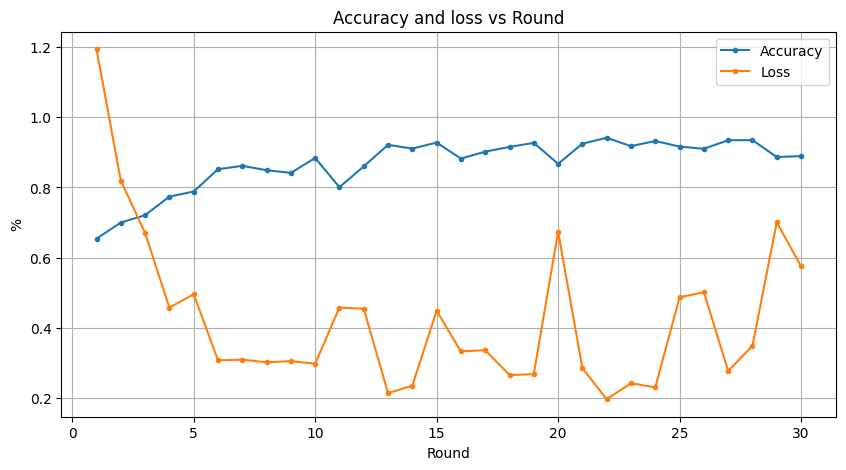

In [7]:
acc = pd.DataFrame(history.metrics_distributed["accuracy"])
loss = pd.DataFrame(history.losses_distributed)

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(acc[0], acc[1], marker='.', label='Accuracy')
plt.plot(loss[0], loss[1], marker='.', label='Loss')
plt.xlabel('Round')
plt.ylabel('%')
plt.title('Accuracy and loss vs Round')
plt.grid(True)
plt.legend()
plt.show()